## PUT BANNER HERE 

# Twitter Sentiment Analysis
Authors: Anita Camlic, Dermot O'Brien, Drew Holcombe
______________________________________________________________________________________________________

## Overview 
Apple wants to be able to understand their users. Since product reviews can have bias, we turned to Twitter. Twitter is a public service for friends, family, and coworkers to communicate and stay connected through the exchange of quick, frequent messages. People post Tweets, which may contain photos, videos, links, and text. These messages are posted to your profile, sent to your followers, and are searchable on Twitter search. 
We are using a dataset with tweets from the 2016 South by Southwest music festival. These tweets are labeled by sentiment (Positive, Neutral, Negative). Each row in the data provides relavant information about the content in each tweet. We used this dataset along with natural language processing techniques to predict tweet sentiment about Apple products and the brand itself.  

## Business Problem

The Apple Product team is constantly looking for changes they can implement to keep users happy. We were asked by Apple's Product team to create a model that can predict the sentiment of a tweet based on it's content. This model will categorize tweets as either positive or negative.

After the tweets are categorized, the Apple Product team can take a look at our words/bigrams with the highest TF-IDF average, and use that to inspire changes in certain products. Or, they can take a look at the negative tweets and the direct complaints that users are making on Twitter. These complaints and statements can then be used to make informed changes to products that users are unhappy about. This model will act as a general filter for finding tweets to provide insight on places of improvement.

In turn, this will allow Apple to better serve their users. It will give them the opportunity to make changes to products, that will hopefully decrease the amount of complaints and increase the positive viewpoints of the Apple and it's products.

## Data Overview

The original dataset contains 3 columns titled 'tweet_text', 'emotion_in_tweet_is_directed_at', and 'is_there_an_emotion_directed_at_a_brand_or_product'. The column 'tweet_text' contains individual tweet content as a string and was renamed 'tweet' for easier understanding. The column 'emotion_in_tweet_is_directed_at' contains strings representing the subject that the tweet is discussing and was renamed 'subject' for simplification. The column 'is_there_an_emotion_directed_at_a_brand_or_product' contains strings representing the percieved emotion being conveyed in the tweet. This column was renamed for 'emotion' for simplification.  

# Data Understanding
In this section, we are going to explore the dataset with visual analysis and then take a deeper dive into the variables with some visualizations. We are expecting to find some missing values and mislabeled data that we can clean later on.

### Import Data and Create Dataframe

In [1]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [2]:
# use this do download stopwords if you haven't done this before - only needs to be done once
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drewh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# loading in dataframe, using special encoder parameter to save it correctly and without errors
df = pd.read_csv('twitter_data.csv',encoding= 'unicode_escape')

In [4]:
# renaming the columns for simplicity purposes
df = df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "subject", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})

### Exploratory Data Analysis (EDA)

In [5]:
# Check rows and columns
df.shape

(9093, 3)

In [6]:
# See what each row looks like
df.head()

,tweet,subject,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
# See what an example tweet looks like 
df['tweet'][0],df['tweet'][2],df['tweet'][4]

('.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)")

In [8]:
# Check descriptive statistics of numeric columns
df.describe()

,tweet,subject,emotion
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [9]:
# looking at the spread of subjects in our data
df['subject'].value_counts(normalize=True)

iPad                               0.287451
Apple                              0.200851
iPad or iPhone App                 0.142814
Google                             0.130659
iPhone                             0.090246
Other Google product or service    0.089031
Android App                        0.024613
Android                            0.023701
Other Apple product or service     0.010635
Name: subject, dtype: float64

In [10]:
# looking at the spread of emotions in our data
df['emotion'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [11]:
# Check for NaN's
df.isna().sum()

tweet         1
subject    5802
emotion       0
dtype: int64

# Data Preparation
Here we prepare our data to be modeled.

In [12]:
# Here we are converting all the tweets to lowercase, so we don't run in to issues in the future
df['tweet'] = df['tweet'].str.lower()

Here, we are segmenting our data so that it only includes Negative or Positive emotions.We will call this new dataframe 'df_binary'. We are starting with a binary classification at first, and if we have time we will revisit multiclass classification.

In [13]:
# Creating binary class dataframe
df_binary = df.loc[(df['emotion'] == 'Positive emotion' ) | (df['emotion'] == 'Negative emotion' )]

We are now going to assign numeric values to the emotion. We are making the positive class (1) represent tweets with negative sentiment. We are making the negative class (0) represent tweets with positive sentiment. This is a little confusing, however we are doing this so that all of our metrics are focused on the positive class. The tweets we want to ensure classification on our negative tweets. This is because the negative tweets represent areas of improvement for Apple. So, we want to ensure all of the negative tweets are classified correctly, so we can create a more streamlined application process of our model.  

In [14]:
# Relabeling the content of the emotion column
df_binary.loc[df_binary['emotion'] == 'Positive emotion' , 'emotion_label'] = 0
df_binary.loc[df_binary['emotion'] == 'Negative emotion' , 'emotion_label'] = 1

C:\Users\drewh\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\drewh\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Next, we are creating a column named 'company'. This will represent the company the tweet is discussing. 


We do this by writing a function named label_brand that looks at the subject column, and based on the content of that column, will label the company column as either Apple or Google. Next, we take care of the null values in the subject column. If a row has a null value in the subject column, then we look for keywords in tweets, and labels the company accordingly. 

For example, if the tweet contains the words apple, iphone, ipad or itunes, it will be labeled as 'Apple'. On the flip side, if the tweet contains words like google or android, it will be labaled as 'Google. This makes it easier to tell which brand the tweet is targeting. It also decreases the complexity of the subject column. We now have only two labels: Apple and Google, instead of the previous 8. 

In [15]:
# function to label new column based on the product category 

def label_brand(row):
    if row['subject'] == 'iPad':
        return 'Apple'
    elif row['subject'] == 'Apple':
        return 'Apple'
    elif row['subject'] == 'iPad or iPhone App':
        return 'Apple'
    elif row['subject'] == 'iPhone':
        return 'Apple'
    elif row['subject'] == 'Other Apple product or service':
        return 'Apple'
    elif row['subject'] == 'Google':
        return 'Google'
    elif row['subject'] == 'Other Google product or service':
        return 'Google'
    elif row['subject'] == 'Android App':
        return 'Google'
    elif row['subject'] == 'Android':
        return 'Google'
    elif row['subject'] == np.nan: 
        return np.nan

In [16]:
# Applying label_brand to all rows in df_binary
df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)

<ipython-input-16-5e3ea6029349>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)


In [17]:
# Creating words to look for in tweets to label company accordingly
apple_words = ['apple','ipad','iphone','itunes']
google_words = ['google','android']

In [18]:
# Creating values for company column based on tweet content
df_binary.loc[(df_binary['subject'].isna()) &
              (df_binary['tweet'].str.contains('|'.join(apple_words))),'company'] = 'Apple'

In [19]:
# Creating values for company column based on tweet content
df_binary.loc[(df_binary['subject'].isna()) &
              (df_binary['tweet'].str.contains('|'.join(google_words))),'company'] = 'Google'

In [20]:
# We drop the remaining 11 rows with nulls in the company column
df_binary.dropna(subset=['company'],inplace=True)

<ipython-input-20-d1d5d522b508>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary.dropna(subset=['company'],inplace=True)


#### Train Test Split
We are making a train test split that contains only the tweet column and the emotion_label column.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_binary['tweet'],
                                                    df_binary['emotion_label'], train_size=.9)

Below we import the default stopword list from nltk.corpus library

In [22]:
# creating the og_stopwords word list to be used in modeling
og_stopwords = stopwords.words('english')

# Data Modeling
This is where we begin our modeling.

### Baseline Model - Naive Bayes
Here we are creating our baseline model. For this baseline, our model will predict the most frequent class ( positive emotion ) for every tweet. So, the accuracy score should equal the percentage of the data that is actually conveying positive emotion in their tweet (83%).

The regular expression pattern we are using for our vectorizer is r"([a-zA-Z]+(?:'[a-z]+)?)". We are using this pattern because it only accepts uppercase and lowercase letters as tokens. This is great for our model since we don't need extrenuous symbols like hashtags (#), at symbols(@), or any other type of punctuation (!*&...). This regex pattern also does not accept numbers. So this takes care of unwanted tokens from things like dates and times.

For now, we are using the standard list of English stopwords (henceforth "og_stopwords") - we will add additional stop words later in the process.

We are using MultinomialNB (Multinomial Naive Bayes) as our algorthim of choice because it works very well with nlp classification. This is because it assumes that all features are independent of each other, making it very powerful for this type of classifcation.

In [23]:
# Creating a TFIDF Vectorizer Object 
tfidf_baseline = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
baseline_vectorized = tfidf_baseline.fit_transform(X_train)

In [24]:
# Instantiating our baseline algorithm
baseline_model = MultinomialNB()

In [25]:
# Evaluate the classifier on baseline_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, baseline_vectorized, y_train)
baseline_cv.mean()

0.8482583454281567

In [26]:
# Finding training accuracy score 
baseline_model.fit(baseline_vectorized,y_train)
baseline_train_score = baseline_model.score(baseline_vectorized,y_train)
print(baseline_train_score)

0.860823122840088


In [27]:
# Evaluating recall metric
y_pred_baseline = baseline_model.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.114

### Iteration 1: Decision Tree

Next, we'll try a decision tree model to improve accuracy. A training accuracy score of 1 (or very near one) will indicate that, although the model is overfit, there isn't anything wonky with the data.

In [28]:
tfidf_1 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_1 = tfidf_1.fit_transform(X_train)

In [29]:
# Instantiating our Decision Tree Classifier
dt = DecisionTreeClassifier()

In [30]:
# Evaluate the classifier on vectorized X_train and y_train
cv1 = cross_val_score(dt,vectorized_1, y_train)
cv1.mean()

0.8394651619719005

In [31]:
# finding training accuracy score 
dt.fit(vectorized_1,y_train)
dt1_score = dt.score(vectorized_1,y_train)
print(dt1_score)

0.9996858309770656


In [32]:
# Evaluating recall score
y_pred_dt = dt.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.114

## Iteration 2: Random Forest

After a decision tree, we created a Random Forest model with minimal hyperparameters. While its improvement in accuracy is small, this model produced a higher recall score, more successfully flagging negative tweets. As such, we decided to continue using random forests in future iterations.

In [33]:
tfidf_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_2 = tfidf_2.fit_transform(X_train)

In [34]:
# Instantiating a Random Forest Classifier Object
rf = RandomForestClassifier()

In [35]:
# Evaluate the random forest
cv2 = cross_val_score(rf,vectorized_2, y_train)
cv2.mean()

0.8737058538945333

In [36]:
# finding training accuracy  score 
rf.fit(vectorized_2,y_train)
rf1_score = rf.score(vectorized_2,y_train)
print(rf1_score)

0.9990574929311969


In [37]:
#Evaluating recall
y_pred_rf = rf.predict(vectorized_2)
recall_score(y_train, y_pred_rf)

0.994

## Iteration 3: Vectorizer 

For this iteration, we are looking at which tf-idf vectorizer parameters work best for our data. Think of it kind of like a grid search but for the vectorizer. We found that the best parameter for min_df is 5 and the best input for our ngram_range parameter is (1,2) (allowing unigrams and bigrams).

For this iteration, we will stick with the algorithm that gave us the highest score (random forest).

In [38]:
tfidf_3 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_3 = tfidf_3.fit_transform(X_train)


In [39]:
# Evaluate the random forest on vectorizer with best parameters
cv3 = cross_val_score(rf,vectorized_3, y_train)
cv3.mean()

0.8702487090627253

In [40]:
# finding training score 
rf.fit(vectorized_3, y_train)
rf2_score = rf.score(vectorized_3, y_train)
print(rf2_score)

0.9996858309770656


In [41]:
# Evaluating recall score
y_pred_rf2 = rf.predict(vectorized_3)
recall_score(y_train, y_pred_rf2)

0.998

## Iteration 4 - Random Forest

For this iteration, we will do a grid search on the random forest hyperparameters to find the ones that yield the highest accuracy and recall scores.

In [42]:
tfidf_4 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_4 = tfidf_4.fit_transform(X_train)

In [43]:
# grid search for random forest parameters
grid_rf1 = {"n_estimators":[100, 200, 300],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [10,20,30,None],
            "min_samples_leaf" : [1,2,4],
            "min_samples_split": [2,5,10]
            }
GS_rf1 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf1,
    verbose=2)

We have commented out the gridsearch below, as it takes a significant amount of time to run. Their results are written manually as markdown cells.

In [44]:
# GS_rf1.fit(vectorized_4,y_train)

In [45]:
# GS_rf1.best_params_

{'criterion': 'gini',

'max_depth': None,

'max_features': 'auto',

'min_samples_leaf': 1,

'min_samples_split': 2,

'n_estimators': 200}

In [46]:
# GS_rf1.best_score_

0.8695299008634473

Subsequent gridsearches contain fewer folds and require much less time to run, so they are not commented out like the first one.
 
Now, we are doing another grid search for the Random Forest Classifier.

In [47]:
# grid search for random forest parameters
grid_rf2 = {"n_estimators":[150, 200, 250],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [1,2,3]
            }
GS_rf2 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf2,
    n_jobs=-1,
    verbose=2)

In [48]:
GS_rf2.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.3s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [49]:
GS_rf2.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 250}

In [50]:
GS_rf2.best_score_

0.8737053602282712

Again, we are continuning the random forest grid searches to get the best possible parameters.

In [51]:
# grid search for random forest parameters
grid_rf3 = {"n_estimators":[175, 200, 225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [3,4,5]
            }
GS_rf3 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf3,
    n_jobs=-1,
    verbose=2)

In [52]:
GS_rf3.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.2s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [175, 200, 225]},
             verbose=2)

In [53]:
GS_rf3.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 175}

In [54]:
GS_rf3.best_score_

0.8740208129696001

In [55]:
rf3 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [56]:
# Evaluate the random forest
cv4 = cross_val_score(rf3, vectorized_4, y_train)
cv4.mean()

0.8686783566837475

In [57]:
# finding training score 
rf3.fit(vectorized_4, y_train)
rf3_score = rf3.score(vectorized_4, y_train)
print(rf3_score)

0.9996858309770656


In [58]:
#Evaluating recall
y_pred_rf3 = rf3.predict(vectorized_4)
recall_score(y_train, y_pred_rf3)

0.998

After three grid searches, we seem to have found the most optimal hyperparameter values for our chosen hyperparameters. Our accuracy has increased, albeit only slightly from our baseline model. We also have a significant improvement in recall, indicating we are successfully flagging almost all negative-emotion tweets. However, our training score is much higher than our cross-validation score, signifying that our model is very overfit. With that awareness, we can later try to tweak the vectorizer's paramaters to reduce complexity and possibly reduce overfitting.

## Incorporating Additional Stopwords

Although we removed common english stopwords, there are additional stopwords specific to this data that we will want to remove to attempt to increase our models performance. To do this, we want to first compare the words from both the positive and negative sentiment lists that have high tf-idf scores and see if there is any overlap. If shared words are not useful in evaluating sentiment, we will remove them. Note that we are only looking at the top 10 words for each list and removing stricly from there - removing too many words can lead to a less robust model.

In [59]:
# Create dataframes for positive and negative words
word_eval = pd.concat([X_train, y_train], axis=1)
word_eval_pos = word_eval.loc[word_eval["emotion_label"] == 0]
word_eval_neg = word_eval.loc[word_eval["emotion_label"] == 1]

### Positive Words

In [60]:
# Create a top 10 words for positive sentiment
tfidf_pos = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

pos_vec = tfidf_pos.fit_transform(word_eval_pos["tweet"])

pos_matrix = pd.DataFrame.sparse.from_spmatrix(pos_vec, columns=tfidf_pos.get_feature_names())

pos_words_sorted = list(pos_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Negative Words

In [61]:
# Create a top 10 words for positive sentiment
tfidf_neg = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

neg_vec = tfidf_neg.fit_transform(word_eval_neg["tweet"])

neg_matrix = pd.DataFrame.sparse.from_spmatrix(neg_vec, columns=tfidf_neg.get_feature_names())

neg_words_sorted = list(neg_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Shared Words

In [62]:
# Evaluate shared words and drop as needed
pos_words_sorted

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone',
 'store']

In [63]:
neg_words_sorted

['sxsw',
 'mention',
 'ipad',
 'iphone',
 'quot',
 'google',
 'apple',
 'rt',
 'rt mention',
 'link']

In [64]:
shared_words = [word for word in pos_words_sorted if word in neg_words_sorted]
shared_words

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone']

In [65]:
# Drop the following words after evaluation
updated_stopwords = og_stopwords.copy()
updated_stopwords.extend(['sxsw', 'mention', 'link', 'apple', 'google', 'quot', 'rt', 'rt mention'])

## Iteration 5 - Random Forest with updated stopwords

Let's use this newly updated stopwords list and see if it has improved our score.

In [66]:
tfidf_5 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5)

vectorized_5 = tfidf_5.fit_transform(X_train)

In [67]:
rf5 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [68]:
# Evaluate the random forest
cv5 = cross_val_score(rf5, vectorized_5, y_train)
cv5.mean()

0.8755891906835304

In [69]:
# finding training score 
rf5.fit(vectorized_5, y_train)
rf5_score = rf5.score(vectorized_5, y_train)
print(rf5_score)

0.9946591266101162


In [70]:
# Evaluating recall
y_pred_rf5 = rf5.predict(vectorized_5)
recall_score(y_train, y_pred_rf5)

0.974

As shown, it has slighly increased our cross val accuracy score.

## Iteration 6 - Random Forest max_depth adjustments

For our last effort at increasing our accuracy score, we want to adjust the max_depth hyperparameter to reduce overfitting and see if that helps.

In [71]:
# Check max_depths of current random forest
[estimator.tree_.max_depth for estimator in rf5.estimators_]

[247,
 252,
 187,
 280,
 263,
 260,
 280,
 170,
 178,
 268,
 241,
 156,
 142,
 162,
 231,
 207,
 285,
 281,
 198,
 246,
 244,
 257,
 236,
 247,
 260,
 299,
 227,
 264,
 273,
 270,
 255,
 245,
 266,
 265,
 220,
 227,
 281,
 234,
 168,
 232,
 255,
 261,
 258,
 247,
 222,
 254,
 241,
 256,
 245,
 267,
 285,
 259,
 166,
 261,
 170,
 263,
 258,
 264,
 263,
 266,
 282,
 246,
 242,
 236,
 254,
 257,
 228,
 263,
 236,
 283,
 178,
 160,
 264,
 307,
 153,
 214,
 271,
 248,
 244,
 321,
 275,
 235,
 256,
 230,
 235,
 282,
 258,
 260,
 166,
 266,
 245,
 261,
 239,
 244,
 252,
 257,
 255,
 175,
 232,
 263,
 199,
 207,
 263,
 269,
 223,
 247,
 245,
 269,
 251,
 266,
 264,
 264,
 175,
 250,
 231,
 187,
 288,
 228,
 257,
 252,
 256,
 278,
 186,
 169,
 260,
 264,
 260,
 149,
 239,
 278,
 273,
 248,
 261,
 201,
 238,
 257,
 233,
 212,
 264,
 266,
 140,
 177,
 243,
 272,
 263,
 258,
 169,
 237,
 175,
 258,
 254,
 219,
 253,
 241,
 244,
 245,
 241,
 262,
 245,
 261,
 225,
 256,
 270,
 260,
 179,
 247,
 274

In [72]:
# grid search for random forest parameters
grid_rf4 = {"n_estimators":[225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [50,100,150,200],
            "min_samples_leaf" : [1],
            "min_samples_split": [3]
            }
GS_rf4 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf4,
    n_jobs=-1,
    verbose=2,
    scoring='recall')

In [73]:
tfidf_6 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5,
                         )
vectorized_6 = tfidf_6.fit_transform(X_train)

In [74]:
GS_rf4.fit(vectorized_6, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.2s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [50, 100, 150, 200],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3], 'n_estimators': [225]},
             scoring='recall', verbose=2)

In [75]:
GS_rf4.best_params_

{'criterion': 'gini',
 'max_depth': 200,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 225}

In [76]:
GS_rf4.best_score_

0.316

### Run Final Model on Test Set

With little option and time to improve, we settled on our final model and will now run it on unseen data.

In [77]:
# Transform X_test
test_vec = tfidf_5.transform(X_test)

In [78]:
# Evaluating recall
test_pred = rf5.predict(test_vec)
recall_score(y_test, test_pred)

0.391304347826087

In [79]:
# Evaluate accuracy score
accuracy_score(y_test, test_pred)

0.8700564971751412

In [80]:
# Evaluate precision score
precision_score(y_test, test_pred)

0.8709677419354839

Our final model's accuracy score on the test data is similar to its cross-validation score on the training data (~87% compared to ~87.5%). Notably, its recall score has dropped dramatically compared to the model's performance on the training data. This will be an area of growth we can look into with additional time and resources.

# Model Visualization

### Word Importance Bar Graph

In [81]:
vectorized_5 = tfidf_5.fit_transform(X_train)

In [82]:
final_s_matrix= pd.DataFrame.sparse.from_spmatrix(vectorized_5, columns=tfidf_5.get_feature_names())

In [83]:
final_10_words = final_s_matrix.mean(axis=0).sort_values(ascending=False).head(5)

In [84]:
final_10_df = final_10_words.to_frame()

In [85]:
final_10_df = final_10_df.reset_index()

In [86]:
final_10_df.rename(columns={"index": "word", 0: "tfidf_score"},inplace=True)

In [87]:
final_10_df

,word,tfidf_score
0,ipad,0.055179
1,iphone,0.036082
2,store,0.031054
3,app,0.025352
4,new,0.020729


[Text(0.0, 0, 'ipad'),
 Text(1.0, 0, 'iphone'),
 Text(2.0, 0, 'store'),
 Text(3.0, 0, 'app'),
 Text(4.0, 0, 'new')]

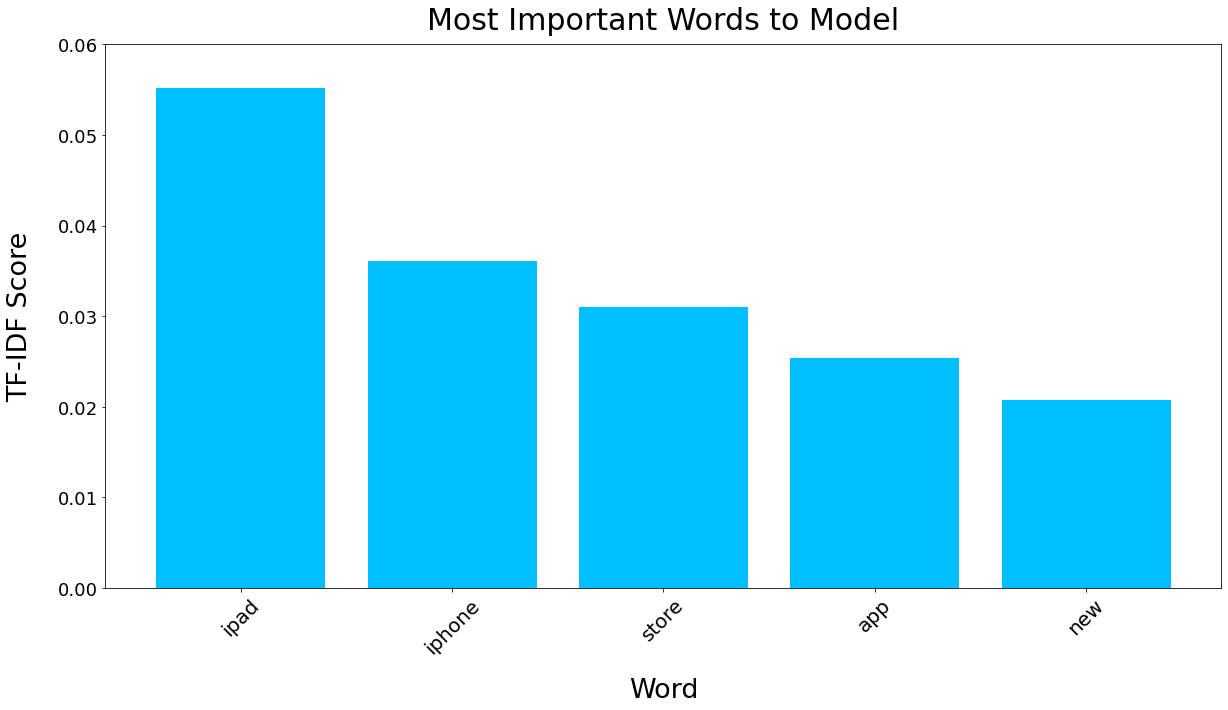

In [88]:
# Visualize word Importance

# Create variables for chart
important_words_x = final_10_df['word']
words = final_10_df['tfidf_score']

c = ['deepskyblue', 'deepskyblue','deepskyblue', 'deepskyblue',
     'deepskyblue']

# Change font family
#plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))
bars = ax.bar(x = important_words_x, height = words,color= c)
ax.set_xlabel('Word', fontsize=27, labelpad=20) 
ax.set_ylabel('TF-IDF Score', fontsize=27, labelpad=25)
ax.set_title('Most Important Words to Model', fontsize=30, pad=15)
ax.tick_params(axis='y', labelsize=18)
#ax.set_yticks(fontsize=12)
ax.set_ylim(0, 0.060, 0.005)
ax.set_xticks(important_words_x)
ax.set_xticklabels(important_words_x, fontsize=20, rotation=45)
#labels = list(colors.keys())
#handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.savefig('./visuals/Final_Model_Top_10_Words_Transparent.png', bbox_inches='tight',transparent=True);



[Text(0.0, 0, 'ipad'),
 Text(1.0, 0, 'iphone'),
 Text(2.0, 0, 'store'),
 Text(3.0, 0, 'app'),
 Text(4.0, 0, 'new')]

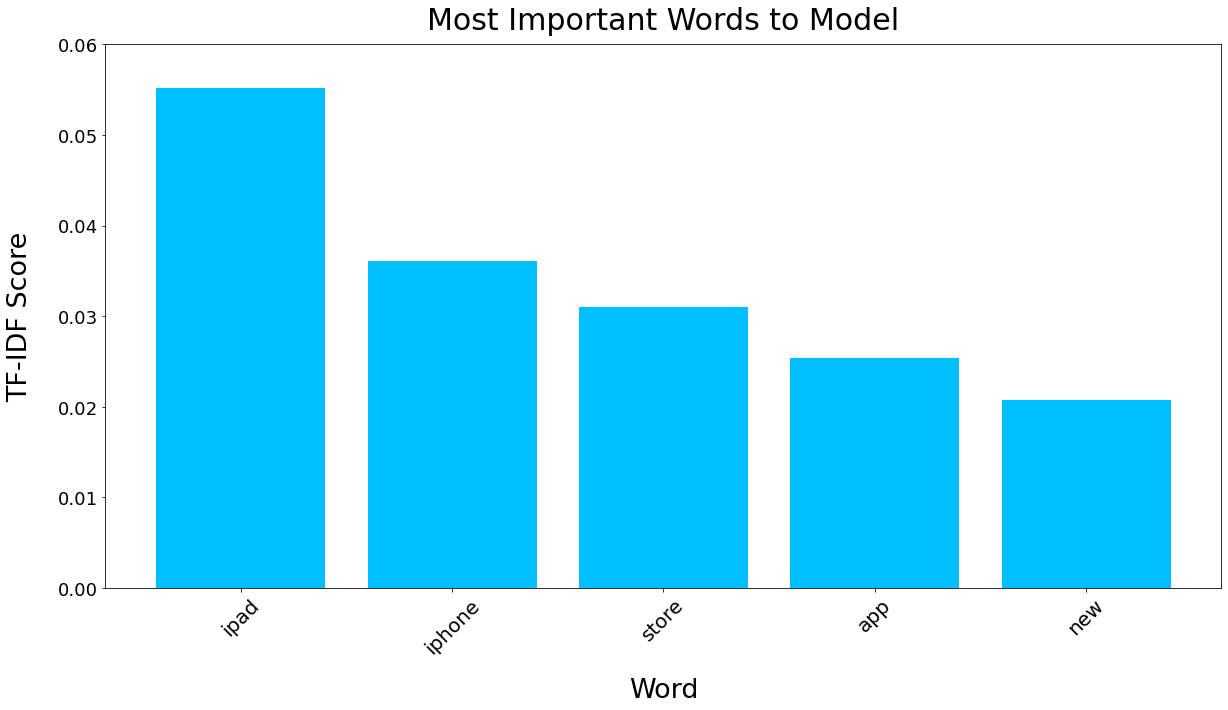

In [89]:
# Visualize word Importance

# Create variables for chart
important_words_x = final_10_df['word']
words = final_10_df['tfidf_score']

c = ['deepskyblue', 'deepskyblue','deepskyblue', 'deepskyblue',
     'deepskyblue']

# Change font family
#plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))
bars = ax.bar(x = important_words_x, height = words,color= c)
ax.set_xlabel('Word', fontsize=27, labelpad=20) 
ax.set_ylabel('TF-IDF Score', fontsize=27, labelpad=25)
ax.set_title('Most Important Words to Model', fontsize=30, pad=15)
ax.tick_params(axis='y', labelsize=18)
#ax.set_yticks(fontsize=12)
ax.set_ylim(0, 0.060, 0.005)
ax.set_xticks(important_words_x)
ax.set_xticklabels(important_words_x, fontsize=20, rotation=45)
#labels = list(colors.keys())
#handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.savefig('./visuals/Final_Model_Top_10_Words_Transparent.png', bbox_inches='tight',transparent=True);



### Recreate Positive and Negative Lists for WordCloud

#### Positive Words

In [90]:
tfidf_pos_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

pos_vec_2 = tfidf_pos_2.fit_transform(word_eval_pos["tweet"])

pos_matrix_2 = pd.DataFrame.sparse.from_spmatrix(pos_vec_2, columns=tfidf_pos_2.get_feature_names())

pos_words_sorted_2 = list(pos_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [91]:
# pos_words_sorted_2

#### Negative Words

In [92]:
tfidf_neg_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

neg_vec_2 = tfidf_neg_2.fit_transform(word_eval_neg["tweet"])

neg_matrix_2 = pd.DataFrame.sparse.from_spmatrix(neg_vec_2, columns=tfidf_neg_2.get_feature_names())

neg_words_sorted_2 = list(neg_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [93]:
# neg_words_sorted_2

### Wordcloud

In [94]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [95]:
from wordcloud import WordCloud
from PIL import Image

### Positive Wordcloud

In [96]:
pos_matrix_2.T.sum(axis=1).sort_values(ascending=False).head(30)

ipad          156.131377
iphone         94.161513
store          90.213965
app            71.307474
new            58.771740
austin         56.416413
pop            48.211338
android        45.634919
amp            41.833943
pop store      38.339987
get            36.963736
party          36.939432
great          35.742827
launch         32.141361
line           31.457824
iphone app     31.313554
via            30.912299
free           30.707999
i'm            29.501311
circles        29.396377
time           29.242857
social         27.808419
awesome        27.803341
cool           27.762704
one            27.756192
day            27.146930
maps           27.131179
mobile         26.768450
like           26.212233
sxswi          25.477761
dtype: float64

In [97]:
pos_matrix_2.drop(['austin', 'pop', 'amp', 'get', 'circles', 'via', 'one', 'time', 'sxswi', "i'm"], axis=1, inplace=True)

In [98]:
custom_mask = np.array(Image.open("./visuals/twitter_positive_mask.png"))
pos_cloud = WordCloud(mask=custom_mask, 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      colormap='Greens', max_words=50).generate_from_frequencies(pos_matrix_2.T.sum(axis=1))

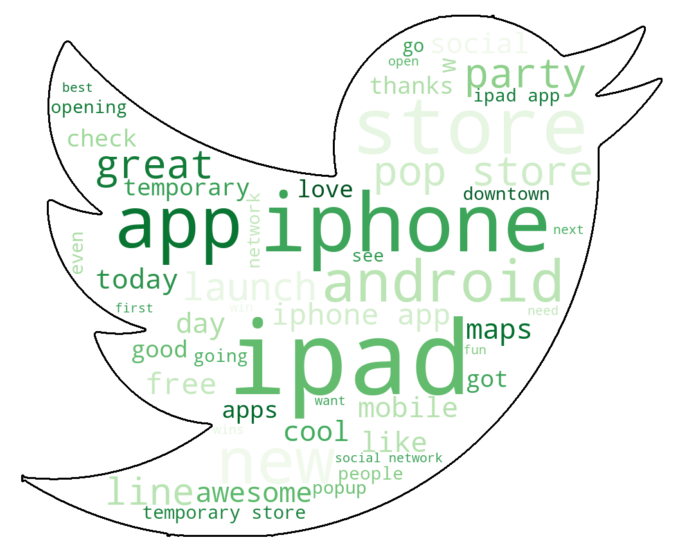

In [99]:
plt.figure(figsize=(15,10))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show();

# pos_cloud.to_file('./visuals/Positive_wordcloud.png')

### Negative Wordcloud

In [100]:
neg_matrix_2.T.sum(axis=1).sort_values(ascending=False).head(30)

ipad                45.777884
iphone              39.567433
app                 19.899525
store               16.815729
like                12.728086
new                 11.555742
austin              10.846690
design              10.547345
circles             10.426304
android             10.016458
iphone app           9.680720
people               9.633594
get                  9.396316
apps                 9.237575
need                 8.743489
fail                 8.426234
says                 8.064878
would                7.936876
social               7.710322
amp                  7.658663
ipad design          7.593518
one                  7.478569
pop                  7.312398
time                 7.302838
day                  7.119752
think                7.078462
design headaches     6.802266
headaches            6.802266
line                 6.762775
long                 6.160969
dtype: float64

In [101]:
neg_matrix_2.drop(['like', 'new', 'austin', 'iphone app', 'apps', 'circles', 'get', 'amp', 'says', 'one', 'time', 'would', 'go', "i'm"], axis=1, inplace=True)

In [102]:
custom_mask = np.array(Image.open("./visuals/twitter_negative_mask.png"))
neg_cloud = WordCloud(mask=custom_mask, 
                      colormap='Reds', 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      max_words=50).generate_from_frequencies(neg_matrix_2.T.sum(axis=1))

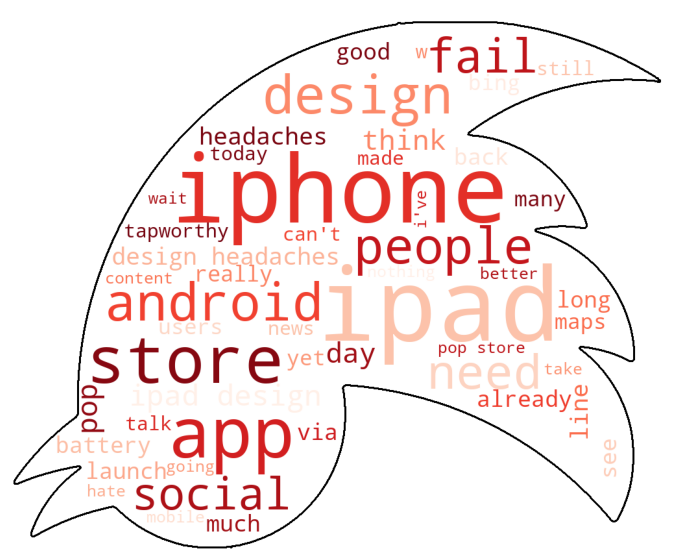

In [103]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(neg_cloud)
plt.axis('off')
plt.show();

# neg_cloud.to_file('./visuals/Negative_wordcloud.png')

# Conclusion

Our model's ability to sort negative from positive tweets can give Apple tools to help identify customer areas of concern. This can give valuable insight in the fields of product development and improvement, marketing, and customer relations. Our model offers a way to parse through the massive amount of customer opinions that are floating through the twitterverse and pull the feedback that will be most valuable to Apple as it seeks to improve public opinion and drive future sales. 

## Limitations and Next Steps

Our data contains a rather limited scope of tweets; while 8,000 is a large number, it is dwarfed by the amount of feedback that exists online. We would love to look into more recent tweets (as use of language evolves rapidly), as well as look into other social media platforms like Facebook and Instagram to test our model's effectiveness in those arenas.

We also had to deal with the large class imbalance between negative and postive tweets; this made it difficult to accurately predict the two. In looking at more recent data, we would be interested in seeing if this class imbalance still exists today.

Lastly, we would be interested in incorporating neutral tweets as a third set. While this category might be more difficult to pick out, as it perhaps uses less characteristic language, it would be conveinent to have a third category to account for those opinions, rather than forcing all tweets about the company into a binary.